In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

import matplotlib.pyplot as plt

In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

losses = []
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch}, Loss: {loss.item()}')


Epoch: 0, Loss: 1.9434483051300049
Epoch: 1, Loss: 1.8269139528274536
Epoch: 2, Loss: 1.659257411956787
Epoch: 3, Loss: 1.5149420499801636
Epoch: 4, Loss: 1.3530967235565186
Epoch: 5, Loss: 1.1932330131530762
Epoch: 6, Loss: 1.069163203239441
Epoch: 7, Loss: 0.941556453704834
Epoch: 8, Loss: 0.8279008865356445
Epoch: 9, Loss: 0.6951894760131836
Epoch: 10, Loss: 0.6516242027282715
Epoch: 11, Loss: 0.5663569569587708
Epoch: 12, Loss: 0.5044646859169006
Epoch: 13, Loss: 0.47351470589637756
Epoch: 14, Loss: 0.36844563484191895
Epoch: 15, Loss: 0.3407968282699585
Epoch: 16, Loss: 0.25134575366973877
Epoch: 17, Loss: 0.27096399664878845
Epoch: 18, Loss: 0.25413432717323303
Epoch: 19, Loss: 0.19734995067119598
Epoch: 20, Loss: 0.20652316510677338
Epoch: 21, Loss: 0.16774699091911316
Epoch: 22, Loss: 0.15460552275180817
Epoch: 23, Loss: 0.13899579644203186
Epoch: 24, Loss: 0.11688567698001862
Epoch: 25, Loss: 0.1260535717010498
Epoch: 26, Loss: 0.10789749771356583
Epoch: 27, Loss: 0.0653191730

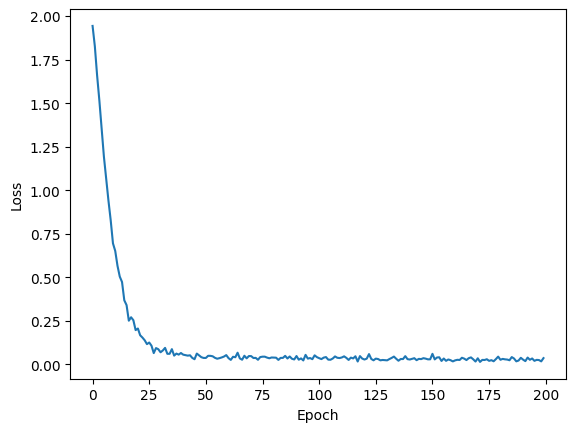

In [5]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
